## Evolution Strategies: Atari

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

[The paper about the algorithm](https://arxiv.org/abs/1703.03864)

In this notebook you should train an agent for one of the simplest and popular Atari game: Pong!

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


### N-grams

A single grame of Atari doesn't contain all the necessary information about the environment state.
We deal with this problem by using 4-frame buffers instead of single frames as input. This is a common trick for so-called "partially observable" environments if you don't want to use RNNs. At first you are going to implement this small hack.

We help you a little bit by setting a good crop and resize so the image will be significantly smaller but the agent will still have all the information.

### Installation of atari:
You have to run `pip install --upgrade gym[atari]==0.19` on your local machine. If you have some problems with the installation, please ask your classmates or google the error message.

In [2]:
pip install --upgrade gym[atari]==0.19

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import gym
from gym.core import Wrapper
from gym.spaces.box import Box
import cv2

def make_pong():
    """creates breakout env with all preprocessing done for you"""
    return PreprocessAtari(gym.make("PongDeterministic-v0"))


class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42,
                 crop=lambda img: img[34:34 + 160], n_frames=4):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        self.img_size = (height, width)
        self.crop = crop
        self.n_frames = n_frames
        self.height = height
        self.width = width

        self.observation_space = Box(0.0, 1.0, [n_frames, height, width])
        self.framebuffer = np.zeros([n_frames, height, width], dtype=float)

    def reset(self):
        """resets breakout, returns initial frames"""
        img = super(PreprocessAtari, self).reset()
        self.reset_buffer()
        self.update_buffer(img)
        return self.framebuffer

    def reset_buffer(self):
        self.framebuffer = np.zeros([self.n_frames, self.height, self.width])

    def step(self, action):
        """plays breakout for 1 step, returns 4-frame buffer"""
        new_img, reward, done, info = super(PreprocessAtari, self).step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    ###image processing###

    def update_buffer(self, img):
        self.framebuffer[:-1] = self.framebuffer[1:]
        self.framebuffer[-1] = self.preproc_image(img)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        img = cv2.resize(src=img,
                       dsize=self.img_size,
                       interpolation=cv2.INTER_CUBIC).mean(-1)
        img = img.astype('float32') / 255.
        return img

In [4]:
env = make_pong()
print(env.action_space)
env.render()

Discrete(6)


True

In [5]:
n_actions = env.action_space.n

### The challenge
Feel free to use everything you did at the seminar. 

If you achieve average score -10, it's the success!

In [6]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import time
from copy import deepcopy
from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display
 
%matplotlib inline

In [7]:
def display_session(env, agent, t_max=500):
    total_reward = 0
    plt.figure(figsize=(4, 3))
    display.clear_output(wait=True)

    s = env.reset()
    
    for t in range(t_max):
        plt.gca().clear()
        
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, info = env.step(a)
        s = new_s
        total_reward += r
        # Draw game image on display.
        plt.imshow(env.render('rgb_array'))

        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        if done:
            break
            
    return total_reward

### Random Policy

In [8]:
class RandomPolicy:
    def __init__(self, n_actions):
        self.n_actions = n_actions
    
    def get_action(self, state):
        return np.random.randint(self.n_actions)

Total reward:  -10.0


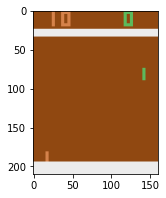

In [9]:
total_reward = display_session(env, RandomPolicy(n_actions))
print('Total reward: ', total_reward)

### Model evaluation

In [10]:
def generate_session(env, agent, t_max=500):
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(torch.tensor(s).float())
        new_s, r, done, info = env.step(a)
        total_reward += r
        s = new_s
        
        if done:
            break
            
    return total_reward


def score(env, agent, n=10, t_max=500):
    rewards = [generate_session(env, agent, t_max) for i in range(n)]
    return np.mean(rewards)

In [11]:
def add_noise_to_model(model, noise, copy=False):
    if copy:
        new_model = deepcopy(model)
    else:
        new_model = model
        
    for param, noise_param in zip(new_model.parameters(), noise):
        param.data += torch.tensor(noise_param, dtype=torch.float)

    return new_model

In [12]:
class EvolutionManager:
    def __init__(self, get_env_function, lr=0.001, std=0.01, t_max=2000, n_samples = 64, n_threads = 1, normalize=True):
        super().__init__()
        
        self.lr = lr
        self.std = std
        self.normalize = normalize
        self.n_samples = n_samples
        self.mean_reward_history = []
        self.n_threads = n_threads
        self.t_max = t_max
        self.last_reward = None
        self.env = get_env_function()
        
    def get_noised_model(self, model):
        noise = [self.std * np.random.randn (*param.shape) for param in model.parameters ()]
        return add_noise_to_model(model, noise, True), noise

    def optimize(self, model, noises, rewards):
        total_noise = []
        for i, p in enumerate (model.parameters ()):
            total_noise.append (np.zeros_like(p.cpu().detach().numpy ()))
            for noise, r in  zip (noises, rewards):
                total_noise[-1] += r * noise[i] / (self.std ** 2) * self.lr / len(noises)

        add_noise_to_model (model, total_noise, copy=False)
    
    def step(self, model):
        rewards = []
        noises = []
        models = []
        for _ in range (self.n_samples):
            noised_model, noise = self.get_noised_model(model)  
            noises.append(noise)
            models.append(noised_model)

        if self.n_threads == 1:
            for i in range(self.n_samples):
                rewards.append(score(self.env, models[i], t_max=self.t_max))
            print(rewards)
        else:
            rewards = np.array(Parallel(n_jobs=self.n_threads)(
                                  delayed(score)(deepcopy(self.env),
                                                 models[i],
                                                 10,
                                                 self.t_max
                                                 )
                                  for i in range(self.n_samples)))
        
        rewards = np.array (rewards)
        normed_rewards = np.copy (rewards)
        if self.normalize: 
            normed_rewards -= np.mean (rewards)
            normed_rewards /= np.std(rewards) + 1e-3
        self.optimize (model, noises, normed_rewards)
        self.update_log (rewards)
        
    def update_log(self, rewards):
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()
        self.last_rewards = rewards
        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()

In [13]:
tmp_env = make_pong()

n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n
n_frames = tmp_env.n_frames

n_states, n_actions, n_frames

(4, 6, 4)

### Conv Policy

In [14]:
def get_h_out(h_in, kernel_size, stride):
    return ((h_in - (kernel_size - 1)) + (stride - 1)) // stride

In [26]:
class ConvPolicy(nn.Module):
    def __init__(self, n_frames, n_actions, height=42, width=42):
        super().__init__()
    
        kernel_size = 3
        stride = 2

        height2 = get_h_out(height, kernel_size, stride)
        width2 = get_h_out(width, kernel_size, stride)

        height3 = get_h_out(height2, kernel_size, stride)
        width3 = get_h_out(width2, kernel_size, stride)

        fully_connected_size = 16 * height3 * width3

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=n_frames, out_channels=8, kernel_size=kernel_size, stride=stride, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel_size, stride=stride, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(fully_connected_size, n_actions, bias=False),            
        )

    def get_action(self, state):
        out = self.model(state.unsqueeze(0).to(torch.float))
        return torch.argmax(out).item()

last mean reward = -19.480


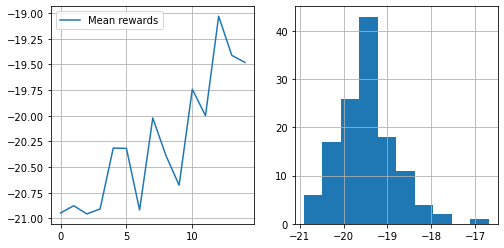

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [1:09:07<00:00, 276.48s/it]

301.3083550930023


In [28]:
from tqdm import tqdm, trange

model = ConvPolicy(n_frames, n_actions)
algorithm = EvolutionManager(make_pong, std=0.01, lr=0.001, n_threads=10, n_samples=128)

for i in trange(15):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

last mean reward = -8.245


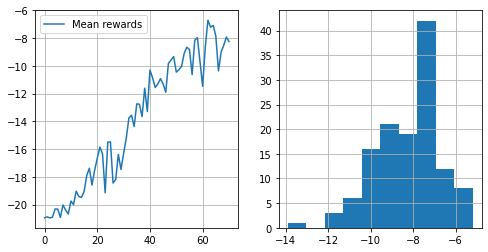

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [2:18:06<00:00, 828.63s/it]

1162.5171220302582


In [38]:
#продолжаем обучать модель

for i in trange(10):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

Total reward:  -3.0


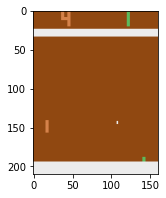

In [39]:
total_reward = display_session(make_pong(), model)
print('Total reward: ', total_reward)

In [40]:
final_score = score(make_pong(), model, n=30, t_max=10000)
print ('Final score: ', final_score)
if final_score > -9:
    print("IT IS WIN!!!")
else:
    print("FAAAAAIL")

Final score:  -9.933333333333334
FAAAAAIL


last mean reward = -5.605


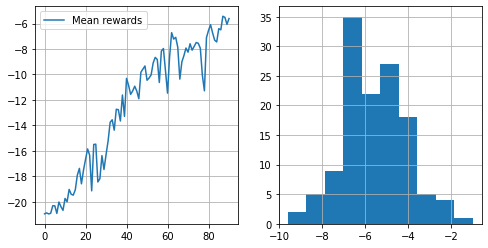

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [11:21:46<00:00, 2045.32s/it]

640.4859488010406


In [42]:
#продолжаем обучать модель

for i in trange(20):
    t = time.time()
    algorithm.step(model)
    print(time.time() - t)

In [43]:
final_score = score(make_pong(), model, n=30, t_max=10000)
print ('Yet another final score: ', final_score)
if final_score > -9:
    print("IT IS WIN!!!")
else:
    print("FAAAAAIL")

Yet another final score:  -7.033333333333333
IT IS WIN!!!


In [50]:
mean_rewards = [score(make_pong(), model, n=30, t_max=5000) for _ in trange(50)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:29:59<00:00, 107.98s/it]


In [53]:
from scipy import stats

alpha = 0.05
m = np.mean(mean_rewards)
se = np.std(mean_rewards)
eps = se * stats.norm.ppf(1 - alpha / 2)

print("95% доверительный интервал", m - eps, m + eps)

95% доверительный интервал -8.34819268014653 -5.3571406531868035


In [55]:
min(mean_rewards), max(mean_rewards)

(-8.333333333333334, -5.233333333333333)

Total reward:  -2.0


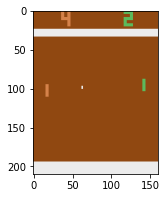

In [47]:
total_reward = display_session(make_pong(), model)
print('Total reward: ', total_reward)

In [48]:
torch.save(model.state_dict(), './model_weights')